# Tracking Keyword Trends in SEC Filings using FinFeedAPI's Full-Text Search

## Introduction

Monitoring the frequency of specific keywords or themes within SEC filings can provide insights into emerging trends, company priorities, and market sentiment. Topics like "ESG" (Environmental, Social, Governance), "artificial intelligence", "inflation", "supply chain", or "cybersecurity" can be tracked over time.

This notebook demonstrates how to use the FinFeedAPI's `/v1/full-text` search endpoint to:
1.  **Define Keywords:** Specify a list of keywords or phrases to track.
2.  **Search Filings Over Time:** Iterate through time periods (e.g., years and months) and search for filings containing each keyword, fetching all matching results by iterating through API response pages.
3.  **Count Occurrences:** Count the total number of filings mentioning each keyword in each period by summing up results from all pages.
4.  **Visualize Trends:** Plot the frequency of keyword mentions over time.

**Note:** Full-text search and fetching all pages can be computationally intensive on the backend and require multiple API calls per search period. Be mindful of API usage, potential costs, and rate limits when searching over long periods or using many keywords.

## Environment Setup

In [1]:
pip install api-bricks-sec-api-rest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.8 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import os
from IPython.display import display
import time # To add delays between API calls if needed
import api_bricks_sec_api_rest

# --- API Configuration ---
API_KEY = "YOUR_API_KEY_HERE"  # <--- REPLACE THIS WITH YOUR ACTUAL KEY!
api_client = api_bricks_sec_api_rest.ApiClient(header_name="Authorization", header_value=API_KEY)

# --- Plotting Configuration ---
try: plt.style.use('seaborn-v0_8-darkgrid')
except OSError: print("Seaborn style not found, using default."); plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)

## 1. Searching Filings for Keywords Over Time (with Full Pagination)

We will loop through each year in our defined range, then through each month, and then through each keyword. For each combination, we'll use the /v1/full-text endpoint and iterate through all available pages to get a complete count of matching filings for that specific month.

**Important:** The `/v1/full-text` endpoint might not return the *total count* of matching filings directly. It usually returns a *paginated list* of matching filings. To get the total count accurately, we would need to either:
    a) Check if the API response includes a total count field (not specified in the provided OpenAPI).
    b) Fetch *all* pages of results for each keyword/year combination and count the total number of records received. This is **extremely API-intensive**.

In [11]:
from datetime import timedelta # Need to import timedelta
import time # Import time for potential delays

# --- Analysis Parameters ---
# Keywords/phrases to track
KEYWORDS_TO_TRACK = [
    "artificial intelligence",
    "inflation",
    "supply chain",
    "cybersecurity",
    "ESG" # Environmental, Social, Governance
]

# Time range for analysis
START_YEAR = 2025
END_YEAR = 2025 # Adjust as needed

# Filing type to search within (e.g., '10-K', '10-Q', or leave empty for all)
TARGET_FORM_TYPE = "10-K" # Focus on annual reports for strategic themes

keyword_trends_monthly = {} # Dictionary to store counts: {keyword: {date (YYYY-MM): count}}
page_size = 200 # Define the page size for pagination
delay_between_pages_seconds = 0.5 # Optional: Add a small delay between page requests

for keyword in KEYWORDS_TO_TRACK:
    print(f"\nTracking keyword: '{keyword}'")
    keyword_trends_monthly[keyword] = {}
    for year in range(START_YEAR, END_YEAR + 1):
        for month in range(1, 13): # Loop through each month (1 to 12)
            # Construct the start and end dates for the month
            start_date_str = f"{year}-{month:02d}-01"
            if month == 12:
                end_date_str = f"{year}-12-31"
            else:
                next_month_date = datetime(year, month + 1, 1)
                end_date_str = (next_month_date - timedelta(days=1)).strftime(f"{year}-%m-%d")

            print(f"  Searching in period: {start_date_str} to {end_date_str} for '{keyword}'")

            total_count_for_period = 0
            page_number = 1

            while True: # Loop to fetch all pages
                print(f"    Fetching page {page_number}...")
                try:
                    results = api_instance.v1_full_text_get (
                        form_type = TARGET_FORM_TYPE,
                        filling_date_start = start_date_str,
                        filling_date_end = end_date_str,
                        text_contains = keyword,
                        page_size = page_size, # Use the defined page size
                        page_number = page_number
                    )

                    if results is not None and isinstance(results, list) and len(results) > 0:
                        # Add the number of results on this page to the total count
                        total_count_for_period += len(results)
                        print(f"      Found {len(results)} results on page {page_number}.")
                        page_number += 1 # Move to the next page

                        # Optional: Add a small delay to avoid hitting rate limits
                        time.sleep(delay_between_pages_seconds)

                    elif results is None or (isinstance(results, list) and len(results) == 0):
                        # No more results or an empty list received, stop pagination
                        print(f"      No more results found or empty response on page {page_number}.")
                        break # Exit the while loop

                    else:
                         # Handle unexpected response format
                         print(f"      Received unexpected response format on page {page_number}. Stopping pagination for this period.")
                         break # Exit the while loop


                except Exception as e:
                    print(f"    An error occurred while fetching page {page_number}: {e}")
                    # Decide how to handle errors - maybe break, or retry
                    break # Stop pagination for this period if an error occurs


            # Store the total count for the period
            date_key = f"{year}-{month:02d}"
            keyword_trends_monthly[keyword][date_key] = total_count_for_period
            print(f"  Total count for '{keyword}' in {date_key}: {total_count_for_period}")

# Convert the results dictionary to a DataFrame for easier plotting
trends_df_monthly = pd.DataFrame(keyword_trends_monthly)
trends_df_monthly.index = pd.to_datetime(trends_df_monthly.index) # Convert index to datetime
trends_df_monthly = trends_df_monthly.sort_index() # Sort by date

print("\nKeyword Trend Data (Full Count, by Month):")
display(trends_df_monthly)


Tracking keyword: 'artificial intelligence'
  Searching in period: 2025-01-01 to 2025-01-31 for 'artificial intelligence'
    Fetching page 1...
      Found 65 results on page 1.
    Fetching page 2...
      No more results found or empty response on page 2.
  Total count for 'artificial intelligence' in 2025-01: 65
  Searching in period: 2025-02-01 to 2025-02-28 for 'artificial intelligence'
    Fetching page 1...
      Found 200 results on page 1.
    Fetching page 2...
      Found 200 results on page 2.
    Fetching page 3...
      Found 200 results on page 3.
    Fetching page 4...
      Found 200 results on page 4.
    Fetching page 5...
      Found 200 results on page 5.
    Fetching page 6...
      Found 200 results on page 6.
    Fetching page 7...
      Found 200 results on page 7.
    Fetching page 8...
      Found 200 results on page 8.
    Fetching page 9...
      Found 200 results on page 9.
    Fetching page 10...
      Found 150 results on page 10.
    Fetching page 11.

,artificial intelligence,inflation,supply chain,cybersecurity,ESG
2025-01-01,65,179,115,271,20
2025-02-01,1950,5564,3529,10122,558
2025-03-01,1584,4071,3147,6029,406
2025-04-01,384,1233,1028,1791,95
2025-05-01,59,162,126,190,5
2025-06-01,0,0,0,0,0
2025-07-01,0,0,0,0,0
2025-08-01,0,0,0,0,0
2025-09-01,0,0,0,0,0
2025-10-01,0,0,0,0,0


## 2. Visualizing Keyword Trends

Now, let's plot the monthly trends stored in the `trends_df_monthly` DataFrame using the full counts obtained through pagination.

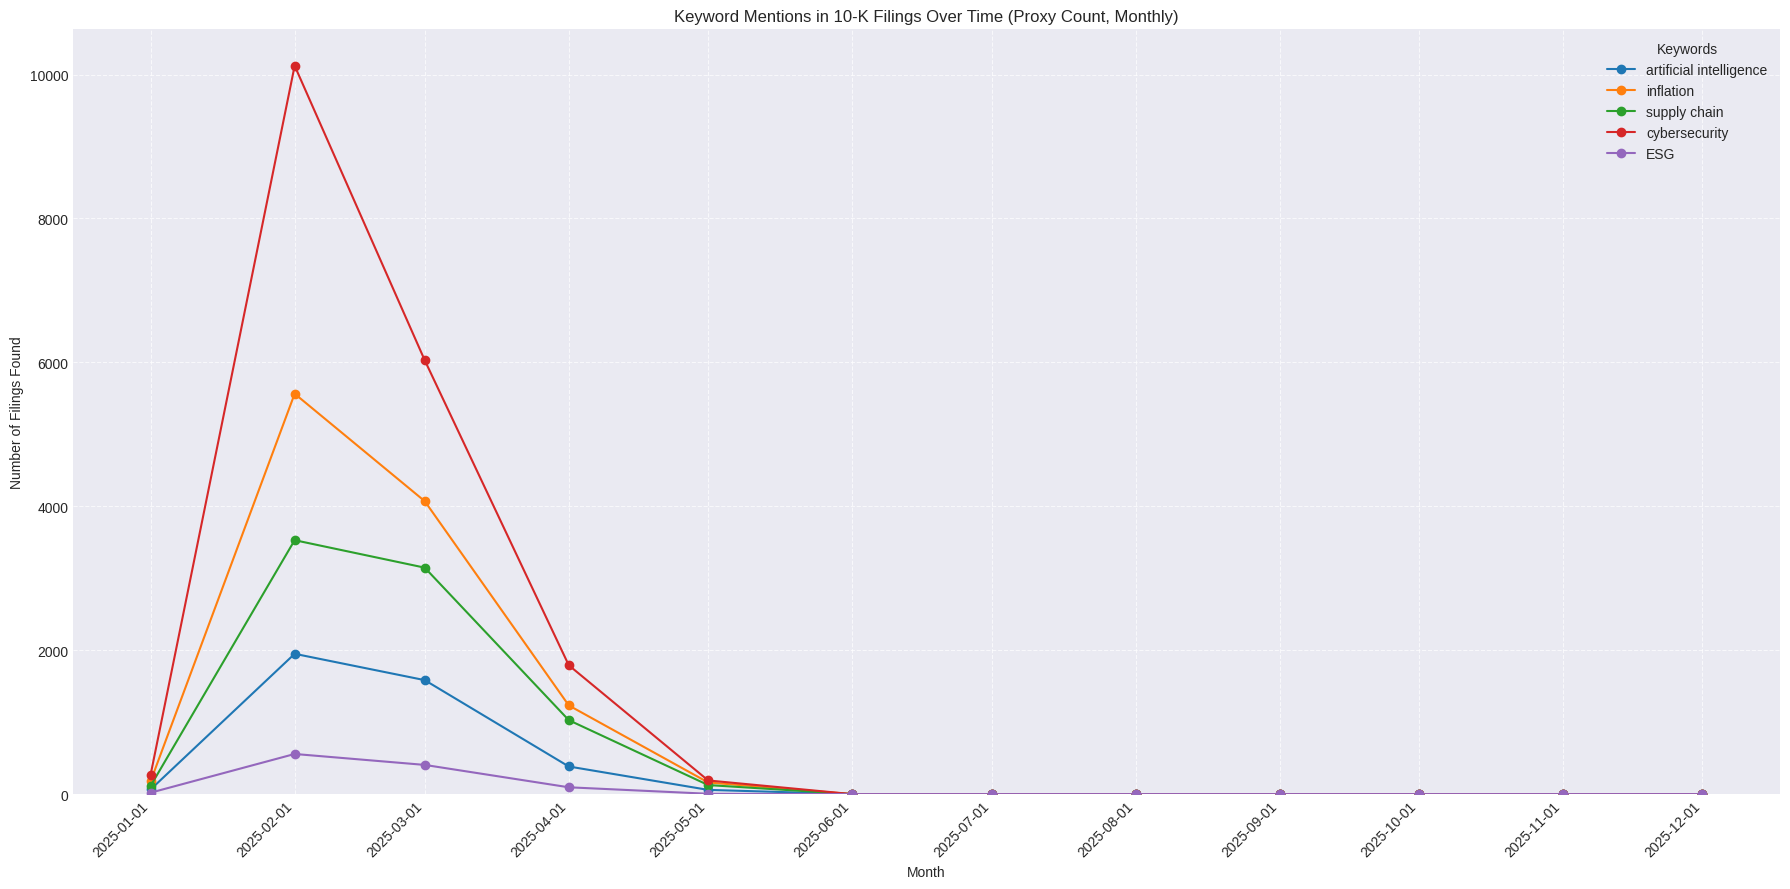

In [12]:
if not trends_df_monthly.empty:
    plt.figure(figsize=(18, 9)) # Adjust figure size for more data points

    for keyword in trends_df_monthly.columns:
        plt.plot(trends_df_monthly.index, trends_df_monthly[keyword], marker='o', linestyle='-', label=keyword)

    plt.title(f'Keyword Mentions in {TARGET_FORM_TYPE or "All"} Filings Over Time (Proxy Count, Monthly)')
    plt.xlabel('Month')
    plt.ylabel(f'Number of Filings Found')
    plt.legend(title="Keywords")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(trends_df_monthly.index, rotation=45, ha='right') # Rotate labels for readability
    plt.ylim(bottom=0)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("No monthly trend data collected to visualize.")

## Conclusion

This notebook demonstrated how to use the FinFeedAPI's `/v1/full-text` search capability to track the prominence of specific keywords within SEC filings over time. By iterating through years and months, and importantly, by implementing full pagination to fetch all results for each time period, we collected accurate total counts and visualized the monthly trends.

**Important Considerations:**

* **API Limits and Cost:** Fetching all pages for each search query significantly increases the number of API calls. Be extremely mindful of potential API rate limits and costs associated with your FinFeedAPI subscription. The added `time.sleep()` is crucial for managing rate limits but increases execution time.
* **Execution Time:** Processing all pages for potentially many keywords over several years can be time-consuming.
* **Keyword Specificity:** The effectiveness depends on choosing relevant and specific keywords. Consider variations and synonyms.

By implementing full pagination, this approach provides a more accurate and robust way to analyze the changing focus and discussion points within corporate disclosures, although it comes with increased API usage and processing time.